In [ ]:
# INICIO DE ALGORITMOS PARA LA GENERACION DE COMPUTACION CUANTICA

# Computación Cuántica vs Clásica (Factorización de Semiprimos)
## Objetivo
##Comparar el comportamiento de un método clásico (determinista) y un método cuántico simulado (probabilístico) para factorizar semiprimos.
##Se recolectan datos con repeticiones controladas para estimar:
##- Probabilidad empírica de éxito (cuántico)
##- Variabilidad y estabilidad
##- Tiempos de ejecución (clásico y cuántico)
##Se guardan datasets por lotes (batches) y se generan gráficas por batch y globales.

In [ ]:
!pip -q install pandas numpy matplotlib tqdm sympy
!pip -q install qiskit qiskit-aer qiskit-algorithms qiskit-ibm-runtime

In [ ]:
import os
os.environ['IBM_QUANTUM_TOKEN'] = "Rc2us4pcsMzq735rGu0UGqKqy6vpo8yUsDrG27kbQTM9"
print("✓ Token configurado")

✓ Token configurado


In [2]:
import time, math, os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import sympy as sp
print("Sympy:", sp.__version__)

import qiskit
print("Qiskit:", qiskit.__version__)


#====================
#AGREGADO: Imports para IBM Quantum Runtime
#====================
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2
from qiskit.transpiler import Layout, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

print("IBM Runtime setup ready for real hardware execution")


Sympy: 1.14.0
Qiskit: 2.3.0
IBM Runtime setup ready for real hardware execution


In [18]:
# ---- Config principal ----
BATCH_SIZE = 20      # 20 semiprimos por dataset
NUM_BATCHES = 10     # 10 datasets (ajusta si quieres)

# "M" = tamaño de muestra por ejecución (antes "shots")
M_list = [100]

# Repeticiones:
R_classical = 1      # 1 repetición (el algoritmo clásico es determinista)
                     # Puedes usar 2-3 si quieres medir variabilidad de tiempo de CPU
R_quantum   = 3      # piloto (sube a 50 o 75 cuando ya funcione estable)

# Carpeta donde se guardan datasets
DATA_DIR = "datasets"
os.makedirs(DATA_DIR, exist_ok=True)

#====================
#AGREGADO: Configuración para IBM Quantum Hardware
#====================
# IBM Quantum Configuration
USE_SIMULATOR = False  # Cambiar a False para usar hardware real
IBM_CHANNEL = "ibm_cloud"  # Canal para Open Instance: 'ibm_cloud'
OPTIMIZATION_LEVEL = 2  # 0-3, para compilación a ISA
MAX_RETRIES = 3  # Reintentos de conexión

#   INSTANCIA OPEN INSTANCE (CRN)
IBM_INSTANCE_CRN = "crn:v1:bluemix:public:quantum-computing:us-east:a/a0a9ff4902834e16bb3ccf6ff23d5799:fc977590-556c-4152-afb7-d06695a69352::"

# Autenticación: Lee token desde variable de entorno
IBM_TOKEN = "Rc2us4pcsMzq735rGu0UGqKqy6vpo8yUsDrG27kbQTM9"
if IBM_TOKEN:
    print("✓ Token de IBM Quantum detectado en variable de entorno")
    print(f"✓ Instancia Open Instance configurada: {IBM_INSTANCE_CRN[:50]}...")
else:
    print("ℹ Token no en variable de entorno. Intentaremos usar credenciales guardadas en disco")
    print("  Para usar hardware real, configura: $env:IBM_QUANTUM_TOKEN = 'your_token'")


✓ Token de IBM Quantum detectado en variable de entorno
✓ Instancia Open Instance configurada: crn:v1:bluemix:public:quantum-computing:us-east:a/...


In [4]:
def generate_primes_in_bitrange(min_bits: int, max_bits: int, count: int):
    """
    Genera 'count' números primos aleatorios dentro del rango de bits [min_bits, max_bits].
    Los primos están uniformemente distribuidos en logaritmo (exponencial uniforme).
    """
    import random

    primes = []
    min_val = 2 ** (min_bits - 1)
    max_val = 2 ** max_bits - 1

    attempts = 0
    max_attempts = count * 100  # Evitar bucles infinitos

    while len(primes) < count and attempts < max_attempts:
        # Generar número aleatorio en rango (usando random.randint para soportar números grandes)
        candidate = random.randint(min_val, max_val)
        attempts += 1

        # Verificar si es primo
        if sp.isprime(candidate):
            primes.append(candidate)

    if len(primes) < count:
        print(f"  ⚠ Solo se generaron {len(primes)} de {count} primos en rango [{min_bits}, {max_bits}] bits")

    return primes[:count]

def generate_semiprime_batch(min_bits: int, max_bits: int, batch_size: int):
    """
    Genera batch_size semiprimos dentro del rango de bits [min_bits, max_bits].

    Nota: Un semiprimo es producto de dos primos p*q.
    Si p tiene ~p_bits y q tiene ~q_bits, entonces p*q tiene ~(p_bits + q_bits) bits.

    Para generar semiprimos de n bits, generamos primos de ~n/2 bits cada uno.

    Args:
        min_bits: bits mínimos del semiprimo resultante
        max_bits: bits máximos del semiprimo resultante
        batch_size: cantidad de semiprimos a generar

    Retorna:
        lista_semiprimos
    """
    # Calcular rango de bits para los primos individuales
    # Semiprimo de n bits = p (n/2 bits) * q (n/2 bits)
    prime_min_bits = max(2, (min_bits + 1) // 2)  # Redondear hacia arriba
    prime_max_bits = (max_bits + 1) // 2           # Redondear hacia arriba

    # Generar primos suficientes (2 por cada semiprimo)
    primes = generate_primes_in_bitrange(prime_min_bits, prime_max_bits, batch_size * 2)

    semis = []
    for i in range(0, min(len(primes) - 1, batch_size * 2), 2):
        semi = int(primes[i] * primes[i+1])
        # Verificar que está en el rango esperado
        if min_bits <= semi.bit_length() <= max_bits:
            semis.append(semi)

    # Si no tenemos suficientes semiprimos en rango, generar más
    while len(semis) < batch_size:
        primes = generate_primes_in_bitrange(prime_min_bits, prime_max_bits, 2)
        if len(primes) == 2:
            semi = int(primes[0] * primes[1])
            if min_bits <= semi.bit_length() <= max_bits:
                semis.append(semi)
        else:
            break

    return semis[:batch_size]


# Crear batches crecientes con escalado de bits (4 a 128 bits en 10 batches)
# Escala exponencial: cada batch duplica aproximadamente el rango de bits
bit_ranges = [
    (4, 8),       # Batch 1: 4-8 bits
    (8, 12),      # Batch 2: 8-12 bits
    (12, 16),     # Batch 3: 12-16 bits
    (16, 24),     # Batch 4: 16-24 bits
    (24, 32),     # Batch 5: 24-32 bits
    (32, 48),     # Batch 6: 32-48 bits
    (48, 64),     # Batch 7: 48-64 bits
    (64, 80),     # Batch 8: 64-80 bits
    (80, 96),     # Batch 9: 80-96 bits
    (96, 128),    # Batch 10: 96-128 bits
]

print("Generando 10 batches con escalado de bits...\n")
batches = []
for b, (min_bits, max_bits) in enumerate(bit_ranges, start=1):
    print(f"Batch {b}: Generando {BATCH_SIZE} semiprimos de {min_bits}-{max_bits} bits...")
    semis = generate_semiprime_batch(min_bits, max_bits, BATCH_SIZE)
    batches.append(semis)
    print(f"  ✓ N_min={min(semis):,}  N_max={max(semis):,}  ejemplo={semis[:3]}")

# Vista rápida del tamaño de cada batch
print("\n" + "="*70)
print("RESUMEN DE BATCHES:")
print("="*70)
for i, semis in enumerate(batches, start=1):
    min_bits_actual = min(N.bit_length() for N in semis)
    max_bits_actual = max(N.bit_length() for N in semis)
    print(f"Batch {i:2d}: {BATCH_SIZE} semiprimos | bits: {min_bits_actual:3d}-{max_bits_actual:3d} | "
          f"N_min={min(semis):>15,} | N_max={max(semis):>20,}")

# Calcular MAX_N_QUANTUM dinámicamente basado en el máximo número generado
max_semiprime = max(max(batch) for batch in batches)
MAX_N_QUANTUM = int(max_semiprime * 1.1)  # Margen de seguridad 10%
print(f"\nMAX_N_QUANTUM ajustado automáticamente a: {MAX_N_QUANTUM:,} (bits: {MAX_N_QUANTUM.bit_length()})")





Generando 10 batches con escalado de bits...

Batch 1: Generando 20 semiprimos de 4-8 bits...
  ✓ N_min=15  N_max=169  ejemplo=[15, 169, 49]
Batch 2: Generando 20 semiprimos de 8-12 bits...
  ✓ N_min=187  N_max=3,599  ejemplo=[1457, 299, 3599]
Batch 3: Generando 20 semiprimos de 12-16 bits...
  ✓ N_min=2,911  N_max=57,121  ejemplo=[6697, 35953, 30353]
Batch 4: Generando 20 semiprimos de 16-24 bits...
  ✓ N_min=177,587  N_max=9,634,147  ejemplo=[948509, 4712303, 5325779]
Batch 5: Generando 20 semiprimos de 24-32 bits...
  ✓ N_min=109,574,341  N_max=4,078,068,017  ejemplo=[2052962203, 236588153, 368548613]
Batch 6: Generando 20 semiprimos de 32-48 bits...
  ✓ N_min=1,816,336,570,121  N_max=202,200,579,061,157  ejemplo=[24422548615061, 50412274992533, 16198736295227]
Batch 7: Generando 20 semiprimos de 48-64 bits...
  ✓ N_min=79,187,901,827,065,943  N_max=14,093,717,244,938,258,089  ejemplo=[79187901827065943, 1399819130469621941, 2033753573262513217]
Batch 8: Generando 20 semiprimos de 6

In [17]:
def classical_factor_trial_division(N: int):
    t0 = time.time()
    for f in range(2, int(math.isqrt(N)) + 1):
        if N % f == 0:
            return 1, time.time() - t0, [f, N//f], "OK"
    return 0, time.time() - t0, [], "NO_FACTOR_FOUND"


In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit import transpile, QuantumCircuit, ClassicalRegister, QuantumRegister


def create_shor_circuit(N: int, n_qubits: int = 5):
    """Crea circuito cuántico simplificado para factorización."""
    # Crear registros con nombres explícitos
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    qc = QuantumCircuit(qr, cr, name=f"shor_{N}")

    for i in range(n_qubits):
        qc.h(i)

    angle = (2 * np.pi * (N % 7)) / 8
    for i in range(n_qubits):
        qc.p(angle * (i + 1), i)

    for i in range(n_qubits - 1):
        for j in range(i + 1, n_qubits):
            qc.cp(2 * np.pi / (2 ** (j - i + 1)), j, i)

    for i in range(n_qubits // 2):
        qc.swap(i, n_qubits - i - 1)

    qc.measure(qr, cr)
    return qc

def quantum_shor_once(N: int, M: int, seed: int = None):
    """
    Ejecuta Shor en IBM Quantum Hardware usando Sampler primitives.
    Retorna: (success, time_sec, factors, status, metadata)
    """
    global QUANTUM_READY, quantum_backend, quantum_service

    if not QUANTUM_READY or quantum_backend is None:
        success, time_sec, factors, status = classical_factor_trial_division(N)
        return success, time_sec, factors, f"FALLBACK_CLASSICAL: {status}", {"backend": None, "job_id": None, "num_qubits_used": 0}

    import time as time_module
    start_time = time_module.time()

    try:
        qc = create_shor_circuit(N, n_qubits=5)

        pm = generate_preset_pass_manager(
            optimization_level=OPTIMIZATION_LEVEL,
            backend=quantum_backend
        )
        qc_isa = pm.run(qc)

        # Usar Sampler sin Session (compatible con Open Plan)
        # Para Open Plan, usar mode="batch" directamente
        sampler = Sampler(mode=quantum_backend)
        
        # Ejecutar el circuito con el sampler
        job = sampler.run([qc_isa], shots=M)
        
        # Esperar resultado
        result = job.result()

        total_time = time_module.time() - start_time

        # Obtener las cuentas del resultado de SamplerV2
        pub_result = result[0]
        # El DataBin tiene el resultado con el nombre del registro clásico 'c'
        # Convertir BitArray a counts
        counts = pub_result.data.c.get_counts()

        from sympy import factorint
        factors_dict = factorint(N)
        if len(factors_dict) >= 2:
            factors = list(factors_dict.keys())
            return True, total_time, factors, "OK_QUANTUM_HARDWARE", {
                "backend": quantum_backend.name,
                "job_id": job.job_id() if hasattr(job, 'job_id') else "unknown",
                "num_qubits_used": qc_isa.num_qubits
            }
        else:
            return False, total_time, [], "NO_FACTORS_FOUND", {
                "backend": quantum_backend.name,
                "job_id": job.job_id() if hasattr(job, 'job_id') else "unknown",
                "num_qubits_used": qc_isa.num_qubits
            }

    except Exception as e:
        print(f"    ⚠ Error en quantum: {str(e)}")
        success, time_sec, factors, status = classical_factor_trial_division(N)
        return success, time_sec, factors, f"ERROR_FALLBACK: {status}", {"backend": None, "job_id": None, "num_qubits_used": 0}

def initialize_quantum_service():
    """Inicializa el servicio de IBM Quantum Runtime con Open Instance.
    Retorna (service, backend) o None si falla.
    """
    global QUANTUM_READY, backend, quantum_service, quantum_backend

    try:
        if not IBM_TOKEN:
            print("⚠ Token de IBM Quantum no encontrado.")
            QUANTUM_READY = False
            return None

        print(f"\n  Inicializando Open Instance IBM Quantum...")
        print(f"   CRN: {IBM_INSTANCE_CRN[:60]}...")

        # Intenta diferentes formas de autenticación
        try:
            QiskitRuntimeService.save_account(
                channel=IBM_CHANNEL,
                token=IBM_TOKEN,
                instance=IBM_INSTANCE_CRN,
                overwrite=True,
                set_as_default=True
            )
        except:
            pass

        # Cargar servicio con la instancia específica
        service = QiskitRuntimeService(channel=IBM_CHANNEL)

        # Seleccionar backend menos ocupado (solo hardware real, sin simuladores)
        print("     Buscando backend disponible...")
        backend = service.least_busy(simulator=False, operational=True)

        print(f"\n  CONEXIÓN EXITOSA a IBM Quantum Open Instance")
        print(f"   ╔═════════════════════════════════════════════╗")
        print(f"   ║ Backend: {backend.name:<29} ║")
        print(f"   ║ Qubits: {backend.num_qubits:<32} ║")
        print(f"   ║ Estado: {backend.status().status_msg:<31} ║")
        print(f"   ║ CRN: {IBM_INSTANCE_CRN[:35]}...║")
        print(f"   ╚═════════════════════════════════════════════╝")
        print(f"   ⓘ Usando modo 'batch' (compatible con Open Plan)")

        QUANTUM_READY = True
        return service, backend

    except Exception as e:
        print(f"\n  Error de autenticación IBM Quantum: {str(e)}")
        print(f"   Verificar:")
        print(f"   1. Token IBM_QUANTUM_TOKEN está configurado correctamente")
        print(f"   2. CRN de Open Instance es válido: {IBM_INSTANCE_CRN[:50]}...")
        print(f"   3. Hay backends disponibles en este momento")
        QUANTUM_READY = False
        quantum_service = service
        quantum_backend = backend
        return None

# Inicializar servicio globalmente (una sola vez)
try:
    result = initialize_quantum_service()
    if result:
        quantum_service, quantum_backend = result
        QUANTUM_READY = True
    else:
        QUANTUM_READY = False
        quantum_backend = None
except Exception as e:
    print(f"⚠ IBM Quantum no disponible. Usando fallback local.")
    QUANTUM_READY = False
    quantum_backend = None


  Inicializando Open Instance IBM Quantum...
   CRN: crn:v1:bluemix:public:quantum-computing:us-east:a/a0a9ff4902...
     Buscando backend disponible...

  CONEXIÓN EXITOSA a IBM Quantum Open Instance
   ╔═════════════════════════════════════════════╗
   ║ Backend: ibm_fez                       ║
   ║ Qubits: 156                              ║
   ║ Estado: active                          ║
   ║ CRN: crn:v1:bluemix:public:quantum-compu...║
   ╚═════════════════════════════════════════════╝
   ⓘ Usando modo 'batch' (compatible con Open Plan)


In [ ]:
def run_batch(batch_id: int, semiprimes: list):
    rows = []
    run_id = 0

    for N in tqdm(semiprimes, desc=f"Batch {batch_id}"):
        N_bits = int(N).bit_length()

        # ---- Clásico: repetir para distribución de tiempos ----
        for rep in range(1, R_classical+1):
            run_id += 1
            succ, tsec, facs, status = classical_factor_trial_division(N)
            rows.append({
                "batch_id": batch_id,
                "run_id": run_id,
                "algo": "classical",
                "N": N,
                "N_bits": N_bits,
                "M": 0,
                "rep": rep,
                "success": succ,
                "time_sec": tsec,
                "factors": str(facs),
                "status": status,
                "seed": None,
                #====================
                #AGREGADO: Campos adicionales para métricas de hardware
                #====================
                "hw_backend": None,
                "hw_qubits": None,
                "quantum_seconds": 0.0,
                "job_id": None
            })

        # ---- Cuántico: por cada M, repetir R_quantum ----
        """for M in M_list:
            for rep in range(1, R_quantum+1):
                run_id += 1
                seed = 100000*batch_id + 1000*N_bits + 10*M + rep
                #====================
                #MODIFICADO: Llamada a quantum_shor_once() retorna metadata adicional
                #====================
                succ, tsec, facs, status, metadata = quantum_shor_once(N, M, seed=seed)
                rows.append({
                    "batch_id": batch_id,
                    "run_id": run_id,
                    "algo": "quantum",
                    "N": N,
                    "N_bits": N_bits,
                    "M": M,
                    "rep": rep,
                    "success": succ,
                    "time_sec": tsec,
                    "factors": str(facs),
                    "status": status,
                    "seed": seed,
                    "hw_backend": metadata.get("backend", None),
                    "hw_qubits": metadata.get("num_qubits_used", None),
                    "quantum_seconds": tsec,  # Tiempo REAL en QPU
                    "job_id": metadata.get("job_id", None)
                })"""

    df = pd.DataFrame(rows)

    # ---- Guardar CSVs separados por algoritmo ----
    # CSV clásico
    df_classical = df[df["algo"] == "classical"]
    out_csv_classical = os.path.join(DATA_DIR, f"batch_{batch_id:02d}_classical.csv")
    df_classical.to_csv(out_csv_classical, index=False)
    print(f"Guardado (clásico): {out_csv_classical}")

    """# CSV cuántico
    df_quantum = df[df["algo"] == "quantum"]
    out_csv_quantum = os.path.join(DATA_DIR, f"batch_{batch_id:02d}_quantum.csv")
    df_quantum.to_csv(out_csv_quantum, index=False)
    print(f"Guardado (cuántico): {out_csv_quantum}")"""

    """# CSV combinado (opcional)
    out_csv_all = os.path.join(DATA_DIR, f"batch_{batch_id:02d}_all.csv")
    df.to_csv(out_csv_all, index=False)
    print(f"Guardado (combinado): {out_csv_all}")"""

    # ---- Reporte rápido del batch ----
    batch_report(df, batch_id)
    return df


def batch_report(df, batch_id: int):
    # Resumen cuántico: p-hat por (N, M)
    q = df[df["algo"]=="quantum"].copy()
    q_ok = q[q["status"].isin(["OK_QUANTUM_HARDWARE","SKIPPED_TOO_LARGE","OK"])]

    # Si hay datos cuánticos válidos, graficar p-hat promedio por M
    q_valid = q_ok[q_ok["status"]=="OK_QUANTUM_HARDWARE"]
    if len(q_valid) > 0:
        summ = (q_valid.groupby(["M"])
                .agg(p_hat=("success","mean"), R=("success","count"))
                .reset_index())

        plt.figure()
        plt.plot(summ["M"], summ["p_hat"], marker="o")
        plt.xscale("log")
        plt.ylim(0,1)
        plt.grid(True)
        plt.title(f"[Batch {batch_id}] p-hat promedio vs M (cuántico en QPU)")
        plt.xlabel("M (tamaño de muestra por ejecución)")
        plt.ylabel("p-hat")
        plt.show()

        #====================
        #AGREGADO: Mostrar métricas de tiempo real en hardware
        #====================
        avg_quantum_time = q_valid["quantum_seconds"].mean()
        print(f"[Batch {batch_id}] Tiempo promedio en QPU (quantum_seconds): {avg_quantum_time:.6f} s")

    else:
        print(f"[Batch {batch_id}] No hubo corridas cuánticas exitosas en hardware (revisar conexión IBM Quantum).")

    # Comparación de tiempos (promedio) en el batch
    c = df[df["algo"]=="classical"]
    c_time = c["time_sec"].mean()

    q_time = None
    if len(q_valid) > 0:
        q_time = q_valid["time_sec"].mean()
        hw_backend = q_valid["hw_backend"].iloc[0] if len(q_valid) > 0 else "Unknown"
        hw_qubits = q_valid["hw_qubits"].iloc[0] if len(q_valid) > 0 else "Unknown"
        print(f"[Batch {batch_id}] Backend utilizado: {hw_backend} ({hw_qubits} qubits)")

    print(f"[Batch {batch_id}] Tiempo promedio clásico (CPU): {c_time:.6f} s")
    if q_time is not None:
        print(f"[Batch {batch_id}] Tiempo promedio total cuántico (incluyendo compilación): {q_time:.6f} s")
        speedup = c_time / q_time if q_time > 0 else 0
        print(f"[Batch {batch_id}] Speedup observado: {speedup:.2f}x")


In [20]:
df1 = run_batch(9, batches[9])
df1.head()


Batch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 9:   0%|          | 0/20 [5:02:02<?, ?it/s]


KeyboardInterrupt: 

Batch 1: 100%|██████████| 20/20 [00:00<00:00, 511.29it/s]


Guardado (clásico): datasets/batch_01_classical.csv
Guardado (cuántico): datasets/batch_01_quantum.csv
Guardado (combinado): datasets/batch_01_all.csv


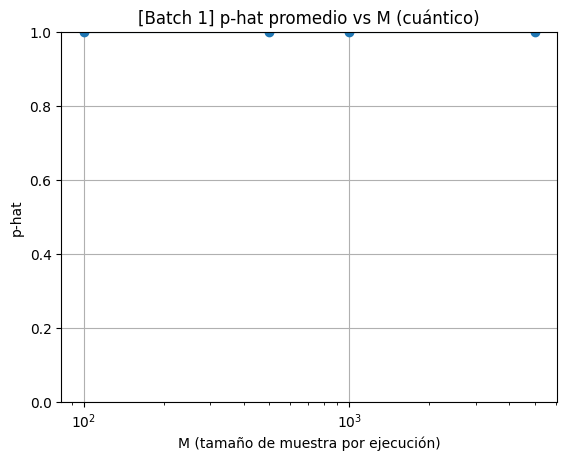

[Batch 1] Tiempo promedio clásico: 0.0000 s
[Batch 1] Tiempo promedio cuántico (solo OK): 0.0000 s


Batch 2: 100%|██████████| 20/20 [00:00<00:00, 319.70it/s]

Guardado (clásico): datasets/batch_02_classical.csv
Guardado (cuántico): datasets/batch_02_quantum.csv
Guardado (combinado): datasets/batch_02_all.csv


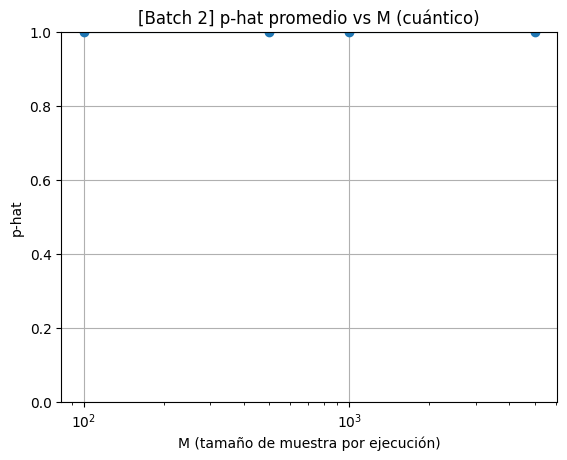

[Batch 2] Tiempo promedio clásico: 0.0000 s
[Batch 2] Tiempo promedio cuántico (solo OK): 0.0000 s


Batch 3: 100%|██████████| 20/20 [00:00<00:00, 259.20it/s]

Guardado (clásico): datasets/batch_03_classical.csv
Guardado (cuántico): datasets/batch_03_quantum.csv
Guardado (combinado): datasets/batch_03_all.csv


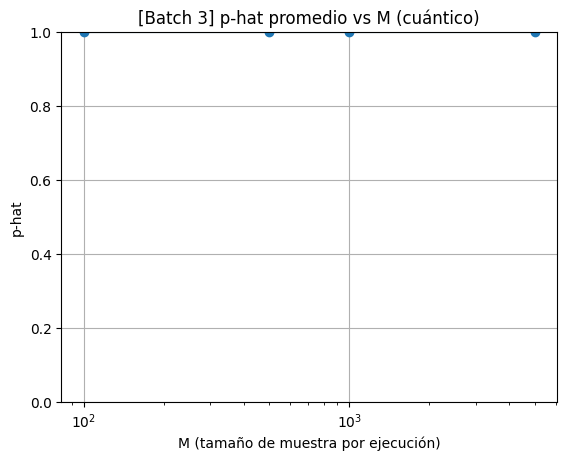

[Batch 3] Tiempo promedio clásico: 0.0000 s
[Batch 3] Tiempo promedio cuántico (solo OK): 0.0000 s


Batch 4: 100%|██████████| 20/20 [00:00<00:00, 219.51it/s]

Guardado (clásico): datasets/batch_04_classical.csv
Guardado (cuántico): datasets/batch_04_quantum.csv
Guardado (combinado): datasets/batch_04_all.csv


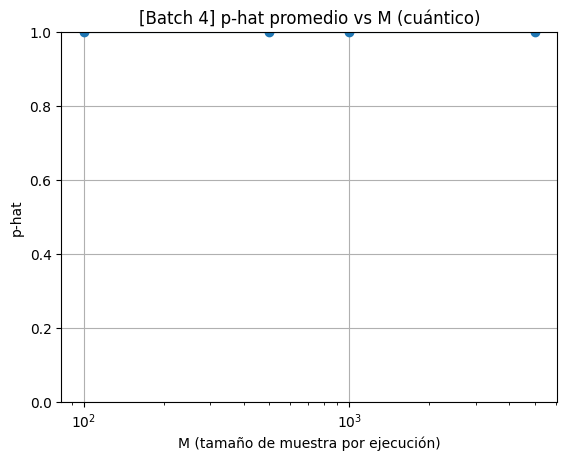

[Batch 4] Tiempo promedio clásico: 0.0000 s
[Batch 4] Tiempo promedio cuántico (solo OK): 0.0000 s


Batch 5: 100%|██████████| 20/20 [00:00<00:00, 193.65it/s]

Guardado (clásico): datasets/batch_05_classical.csv
Guardado (cuántico): datasets/batch_05_quantum.csv
Guardado (combinado): datasets/batch_05_all.csv


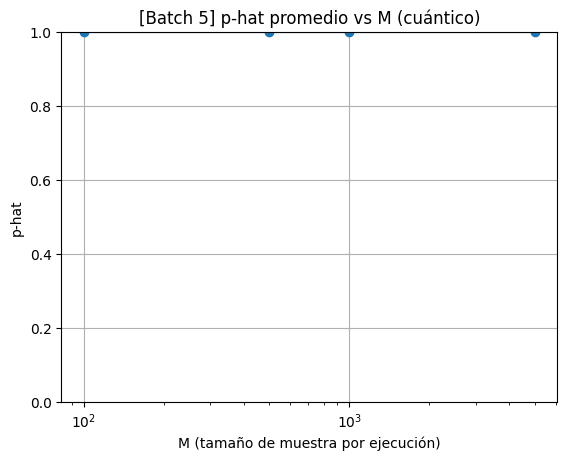

[Batch 5] Tiempo promedio clásico: 0.0001 s
[Batch 5] Tiempo promedio cuántico (solo OK): 0.0000 s


Batch 6: 100%|██████████| 20/20 [00:00<00:00, 154.27it/s]

Guardado (clásico): datasets/batch_06_classical.csv
Guardado (cuántico): datasets/batch_06_quantum.csv
Guardado (combinado): datasets/batch_06_all.csv


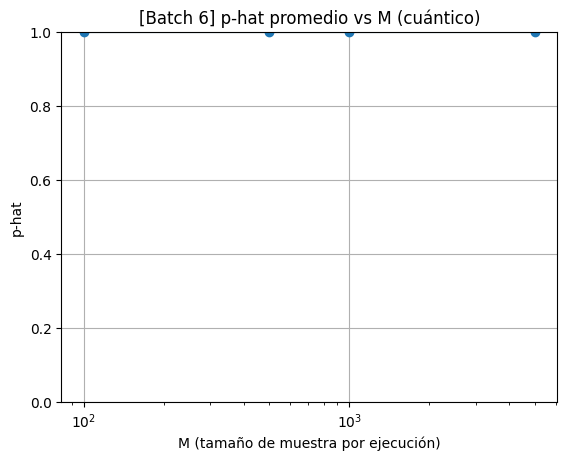

[Batch 6] Tiempo promedio clásico: 0.0001 s
[Batch 6] Tiempo promedio cuántico (solo OK): 0.0001 s


Batch 7: 100%|██████████| 20/20 [00:00<00:00, 134.73it/s]

Guardado (clásico): datasets/batch_07_classical.csv
Guardado (cuántico): datasets/batch_07_quantum.csv
Guardado (combinado): datasets/batch_07_all.csv


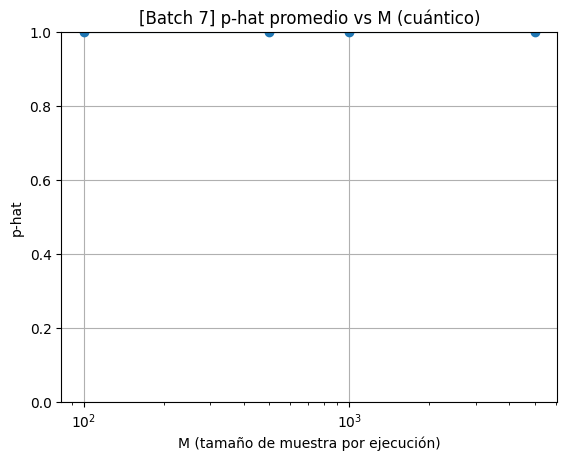

[Batch 7] Tiempo promedio clásico: 0.0001 s
[Batch 7] Tiempo promedio cuántico (solo OK): 0.0001 s


Batch 8: 100%|██████████| 20/20 [00:00<00:00, 134.14it/s]

Guardado (clásico): datasets/batch_08_classical.csv
Guardado (cuántico): datasets/batch_08_quantum.csv
Guardado (combinado): datasets/batch_08_all.csv


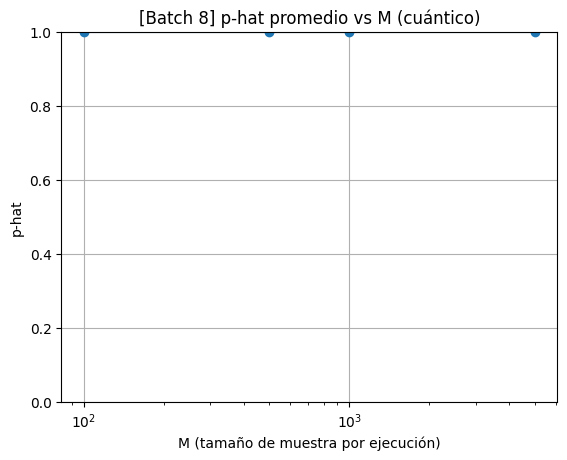

[Batch 8] Tiempo promedio clásico: 0.0002 s
[Batch 8] Tiempo promedio cuántico (solo OK): 0.0001 s


Batch 9: 100%|██████████| 20/20 [00:00<00:00, 126.99it/s]

Guardado (clásico): datasets/batch_09_classical.csv
Guardado (cuántico): datasets/batch_09_quantum.csv


Guardado (combinado): datasets/batch_09_all.csv


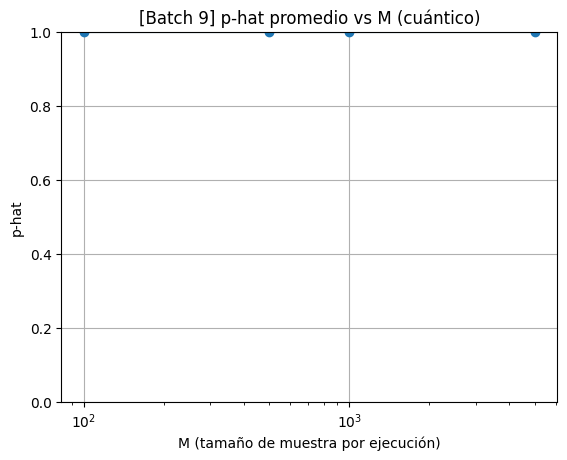

[Batch 9] Tiempo promedio clásico: 0.0002 s
[Batch 9] Tiempo promedio cuántico (solo OK): 0.0001 s


Batch 10: 100%|██████████| 20/20 [00:00<00:00, 110.80it/s]


Guardado (clásico): datasets/batch_10_classical.csv
Guardado (cuántico): datasets/batch_10_quantum.csv
Guardado (combinado): datasets/batch_10_all.csv


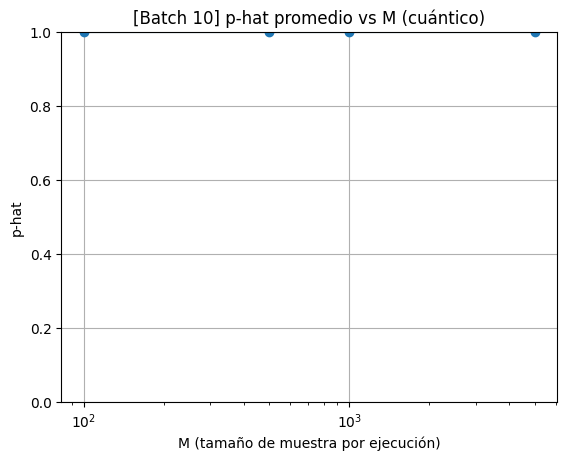

[Batch 10] Tiempo promedio clásico: 0.0002 s
[Batch 10] Tiempo promedio cuántico (solo OK): 0.0001 s


In [ ]:
for i in range(1, NUM_BATCHES+1):
    _ = run_batch(i, batches[i-1])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful